In [2]:
import mxnet as mx
import gluoncv as gcv
import numpy as np
import matplotlib.pyplot as plt
import myutils
import importlib

In [106]:
importlib.reload(myutils)

<module 'myutils' from 'D:\\Documents\\git\\yolo_v1\\myutils.py'>

In [3]:
class Dataset(mx.gluon.data.Dataset):
    def __init__(self, filename):
        super(Dataset, self).__init__()
        import os
        
        windows_dataset_root = r'D:\Documents\Data_Files\Pascal'
        windows_dataset_root2 = r'h:\hlc\Datasets\Pascal'
        linux_dataset_root = '../Dataset/Pascal'
        dataset_root = windows_dataset_root
        img_idx_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'ImageSets', 'Main'])
        self.img_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'JPEGImages'])
        self.annotation_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'Annotations'])
        self.class_name = filename.split('_')[0]
        
        self.img_indices = []
        with open (os.path.sep.join([img_idx_directory, filename]), 'r') as f:
            import re
            import os
            regex = re.compile ('[ ]+')
            while(True):
                line = f.readline()
                if line == '':
                    break
                img_idx, in_the_class = regex.split(line.rstrip('\n'))
                in_the_class = int(in_the_class)
                if (in_the_class == 1):
                    self.img_indices.append(img_idx)
        self.len = len(self.img_indices)
        return


    def __getitem__(self, idx):
        import os
        import mxnet as mx
        import xml.etree.ElementTree as et
        
        img_path = os.path.sep.join([self.img_directory, str(self.img_indices[idx])+'.jpg'])
        img = mx.image.imread(img_path)
        
        label_path = os.path.sep.join([self.annotation_directory, str(self.img_indices[idx])+'.xml'])
        tree = et.parse(label_path)
        root = tree.getroot()
        obj_iter = root.iterfind('object')
        for obj in obj_iter:
            if (obj.find('name').text == self.class_name):
                bndbox = obj.find('bndbox')
                coors = mx.nd.array([int(coor.text) for coor in bndbox])
                label = mx.nd.concat(mx.nd.array([1]), coors, dim=0)
                label = label.reshape(shape=(1, 5))
        return img.asnumpy(), label.astype('int').asnumpy()
    
    
    def __len__(self):
        return self.len
    

dataset = Dataset('cat_train.txt')
print('total num of data entries:', len(dataset))

total num of data entries: 163


In [4]:
batch_size = 10
dataset_for_train = dataset.transform(myutils.transform_fn)
dataloader = mx.gluon.data.DataLoader(dataset_for_train, batch_size=batch_size, shuffle=True)
batchiter = iter(dataloader)
batch_img, batch_label = next(batchiter)
print(batch_img.shape)
print(batch_label.shape)

(10, 3, 300, 300)
(10, 1, 5)


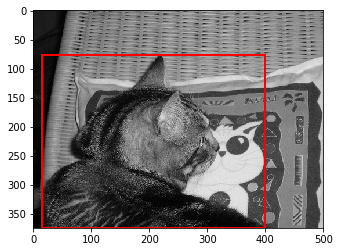

In [5]:
img, label = dataset[3]
myutils.data_visualize(img=img, bboxes=label[:, 1:])

In [6]:
ctx = mx.cpu()
net = gcv.model_zoo.yolo3_darknet53_voc(pretrained=True, root=r'D:\Documents\Data_Files\Parameters', ctx=ctx)

C:\IntelPython3\lib\site-packages\mxnet\gluon\block.py:421: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


In [7]:
i = -1

pic index: 7
(1, 3, 416, 416)


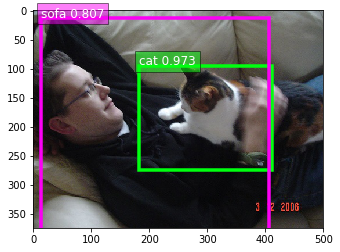

In [15]:
i += 1
print('pic index:', i)
img, label = dataset[i]
# myutils.data_visualize(img=img, bboxes=label[:, 1:])
# plt.show()

img_for_net, label_for_net = myutils.prepare_datum_for_net(img=img, label=label)
print(img_for_net.shape)
output = net(img_for_net)
out_1, out_2, out_3 = output
gcv.utils.viz.plot_bbox(img, out_3[0], out_2[0], out_1[0],
                        class_names=net.classes, thresh=0.5)
plt.show()

有问题，绝对有问题。为啥所有的框都稍偏左上一点？是我对数据 resize 的问题？还是这个网络本身就有问题？？？

对图片 resize 的时候，并不是任何 size 都可以。官方给的一个是 $320\times 320$，另外一个是 $416\times 416$.

$320 \times 320$ 的图片出现左移的现象比较严重，$416 \times 416$ 的图片这个问题改善了许多。

哇！yolo_v3 对小目标的检测也很出众。原版的 ssd 根本测不出来这么小的东西。

？？？ idx=110 的这个图片是怎么回事？label box 好像画得不对啊。。